In [1]:
#Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
#Reading the dataset
dataset = pd.read_excel('Online Retail.xlsx', nrows = 10000)
dataset.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    10000 non-null  object        
 1   StockCode    10000 non-null  object        
 2   Description  9958 non-null   object        
 3   Quantity     10000 non-null  int64         
 4   InvoiceDate  10000 non-null  datetime64[ns]
 5   UnitPrice    10000 non-null  float64       
 6   CustomerID   7709 non-null   float64       
 7   Country      10000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 625.1+ KB


In [4]:
#Checking for missing values

dataset.isnull().sum()

InvoiceNo         0
StockCode         0
Description      42
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     2291
Country           0
dtype: int64

In [5]:
#Drop the rows where the customer ID is missing --> It makes noise in our future matrix construction

dataset.dropna(subset=['CustomerID'], inplace = True)

In [6]:
#Start with the recommendation system
#We convert the customerId into string to facilitate the algorithm later

dataset['CustomerID'] = dataset['CustomerID'].astype(str) 

In [7]:
#Identify the values that are greater than 0 (if there is a return, it will show up as a negative number)

dataset = dataset[(dataset['Quantity']>0) & (dataset['UnitPrice']>0)]

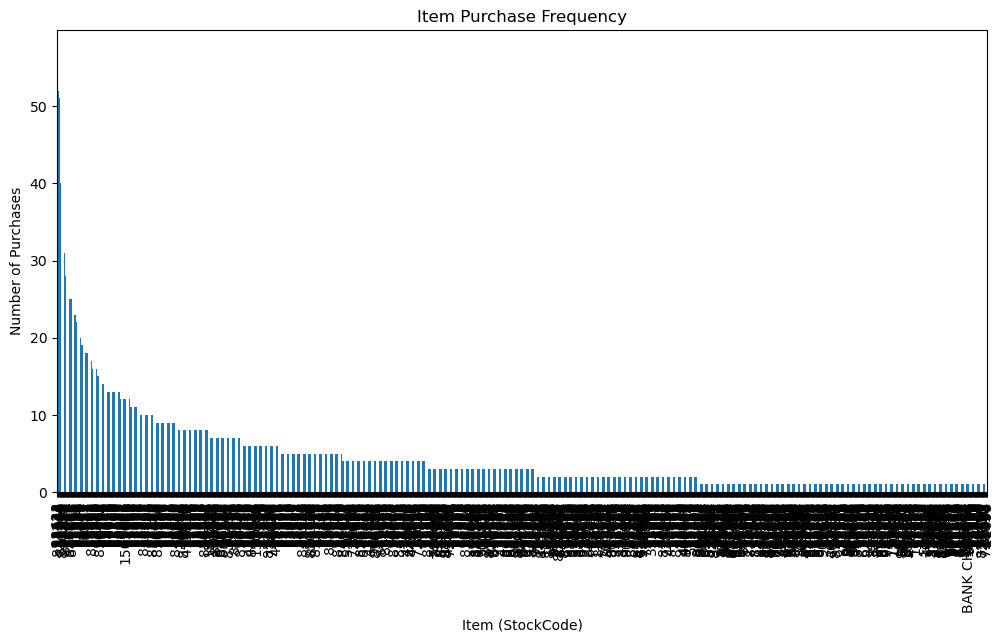

In [27]:
# Item Purchase Frequency
# Calculate the purchase frequency of each item
item_purchase_frequency = dataset['StockCode'].value_counts()

# Create a bar chart to show the purchase frequency of items
plt.figure(figsize=(12, 6))
item_purchase_frequency.plot(kind='bar')
plt.title('Item Purchase Frequency')
plt.xlabel('Item (StockCode)')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=90)  # Rotate item codes for better readability
plt.show()

In [8]:
# Ccreate the User_item matrix --> Understanding the behaviour of the user regarding the items

user_item_matrix = dataset.pivot_table(index='CustomerID', columns = 'StockCode', values = 'Quantity', aggfunc = 'sum').fillna(0)
user_item_matrix.head()


StockCode,10002,10120,10125,10133,10135,11001,15034,15036,15039,16011,...,90200E,90210B,90214J,90214M,90214S,90214V,BANK CHARGES,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
12427.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
12431.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [9]:
#Display the similarities in a dataframe to make it easier to read

user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index = user_item_matrix.index, columns = user_item_matrix.index)
user_similarity_df.head()

CustomerID,12395.0,12427.0,12431.0,12433.0,12472.0,12557.0,12567.0,12583.0,12600.0,12647.0,...,18055.0,18074.0,18085.0,18109.0,18118.0,18144.0,18156.0,18168.0,18229.0,18239.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12395.0,1.000000,0.001016,0.0,0.120145,0.005424,0.0,0.007398,0.000251,0.045507,0.001354,...,0.000000,0.0,0.000000,0.000000,0.082169,0.0,0.000000,0.000000,0.000000,0.000000
12427.0,0.001016,1.000000,0.0,0.000000,0.097313,0.0,0.022310,0.003119,0.003743,0.016819,...,0.000000,0.0,0.000000,0.000000,0.064238,0.0,0.019784,0.000000,0.000000,0.000000
12431.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.008241,0.101972,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.001096,0.046814,0.010355
12433.0,0.120145,0.000000,0.0,1.000000,0.051052,0.0,0.273787,0.040969,0.000000,0.149572,...,0.004935,0.0,0.019917,0.010834,0.059327,0.0,0.123161,0.019822,0.000000,0.000000
12472.0,0.005424,0.097313,0.0,0.051052,1.000000,0.0,0.027789,0.124216,0.001537,0.214054,...,0.000000,0.0,0.008854,0.000000,0.059341,0.0,0.009476,0.000000,0.000000,0.124836


In [10]:
# Rating prediction using the matrix user_item

def predict_ratings_user_based(user_item_matrix, user_similarity):
    mean_user_rating = user_item_matrix.mean(axis = 1).values
    rating_diff = (user_item_matrix.values - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(rating_diff)/np.array([np.abs(user_similarity).sum(axis=1)]).T
    return pred

In [11]:
#Predicted ratings

user_predicted_ratings = predict_ratings_user_based(user_item_matrix, user_similarity)
user_predicted_ratings

array([[-0.00583403, -0.00783887,  0.01907939, ..., -0.00533554,
         0.45671429,  0.43684397],
       [-0.00332743, -0.04794131, -0.02986444, ..., -0.04794131,
         0.07794544,  1.0896085 ],
       [ 1.35052984, -0.07462831, -0.07462831, ..., -0.0711302 ,
        -0.0682343 ,  0.05699184],
       ...,
       [-0.08964638, -0.12832839, -0.1205555 , ..., -0.12819959,
         0.27137129, -0.10542151],
       [ 2.12549299, -0.06664603, -0.06664603, ..., -0.06317765,
         0.02039569,  0.19378369],
       [-0.01317226, -0.0285752 , -0.03184675, ..., -0.03521847,
         0.22303415,  0.06616598]])

In [12]:
#Checking the performance of the algorithm

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

print('User-user collaborative error:', rmse(user_predicted_ratings, user_item_matrix.values))

User-user collaborative error: 39.793287722573005


In [13]:
# Create an item similarity matrix

item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index = user_item_matrix.columns, columns = user_item_matrix.columns)

In [14]:
#Rating for the item collaboration

def predict_ratings_item_based(user_item_matrix, item_similarity):
    pred = user_item_matrix.values.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])
    return pred

#Predict the ratings
item_predicted_ratings = predict_ratings_item_based(user_item_matrix, item_similarity)

#We print the accuracy
print('Item-item collaborative error:', rmse(item_predicted_ratings, user_item_matrix.values))

Item-item collaborative error: 36.930396816952


In [15]:
# reate an item similarity matrix

from scipy.sparse.linalg import svds

In [16]:
#Normalise the data to have the same unit of measurement

user_ratings_mean = np.mean(user_item_matrix.values, axis = 1)
ratings_demeaned = user_item_matrix.values - user_ratings_mean.reshape(-1,1)

In [17]:
# Singular Value Decomposition (SVD)
U, sigma, Vt = svds(ratings_demeaned, k = 50)
sigma = np.diag(sigma)

In [18]:
# Rating prediction
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns = user_item_matrix.columns)

In [19]:
#Evaluation of the model after the SVD
print('SVD collaborative filtering', rmse(predicted_ratings_df.values, user_item_matrix.values))

SVD collaborative filtering 7.270497521339722


In [20]:
#Now, recommend 3 items

def recommended_items(user_id, user_item_matrix, predicted_ratings_df, num_recommendations = 3):
    user_idx = user_item_matrix.index.get_loc(user_id) #sorting the user predicted ratings
    sorted_user_ratings = predicted_ratings_df.iloc[user_idx].sort_values(ascending = False)
    user_data = user_item_matrix.loc[user_id] #appending or merging the user data with the sorted ratings
    user_full = (user_data[user_data >0]).sort_values(ascending = False)
    recommendations = sorted_user_ratings[~sorted_user_ratings.index.isin(user_full.index)]
    return recommendations.head(num_recommendations) # recommendation of items that the user did not buy yet

In [21]:
def normalize_ratings(predicted_ratings):
    min_rating = predicted_ratings.min()
    max_rating = predicted_ratings.max()
    probabilities = (predicted_ratings - min_rating) / (max_rating - min_rating)
    return probabilities

In [22]:
# Recommendation for three random users and display results in a DataFrame

# Select three random users
random_users = np.random.choice(user_item_matrix.index, size=3, replace=False)
random_users

array(['16955.0', '13777.0', '17905.0'], dtype=object)

In [23]:
# Initialize an empty list to store results
recommendations_list = []

# Get recommendations for each random user
for user in random_users:
    recs = recommended_items(user, user_item_matrix, predicted_ratings_df, num_recommendations=3)
    recs = recs.reset_index()
    recs.columns = ['StockCode', 'Probability']
    recs['CustomerID'] = user
    recommendations_list.append(recs)

recommendations_list

[  StockCode  Probability CustomerID
 0     84692     8.656970    16955.0
 1    84534B     4.321386    16955.0
 2     22738     3.903380    16955.0,
    StockCode  Probability CustomerID
 0      21231     0.694651    13777.0
 1      22155     0.682841    13777.0
 2      21807     0.519210    13777.0,
   StockCode  Probability CustomerID
 0     71053     2.514213    17905.0
 1    84406B     2.253164    17905.0
 2     21068     2.149433    17905.0]

In [24]:
# Combine results into a single DataFrame
final_recommendations_df = pd.concat(recommendations_list, ignore_index=True)

# Convert StockCode to string to match with dataset
final_recommendations_df['StockCode'] = final_recommendations_df['StockCode'].astype(str)

final_recommendations_df

,StockCode,Probability,CustomerID
0,84692,8.656970,16955.0
1,84534B,4.321386,16955.0
2,22738,3.903380,16955.0
3,21231,0.694651,13777.0
4,22155,0.682841,13777.0
5,21807,0.519210,13777.0
6,71053,2.514213,17905.0
7,84406B,2.253164,17905.0
8,21068,2.149433,17905.0


In [25]:
# Get dataset descriptions
filtered_data = dataset[['StockCode', 'Description']].drop_duplicates()
filtered_data 

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
9970,22833,HALL CABINET WITH 3 DRAWERS
9974,22690,DOORMAT HOME SWEET HOME BLUE
9978,84881,BLUE WIRE SPIRAL CANDLE HOLDER
9984,21613,S/12 VANILLA BOTANICAL T-LIGHTS


In [26]:
# Merge with the dataset to get descriptions
final_result_df = pd.merge(final_recommendations_df, filtered_data, on='StockCode', how='left')

# Select only the required columns
final_result_df = final_result_df[['CustomerID', 'StockCode', 'Description', 'Probability']]

final_result_df

,CustomerID,StockCode,Description,Probability
0,16955.0,84692,NaN,8.656970
1,16955.0,84534B,FAIRY CAKE NOTEBOOK A5 SIZE,4.321386
2,16955.0,22738,NaN,3.903380
3,13777.0,21231,NaN,0.694651
4,13777.0,22155,NaN,0.682841
5,13777.0,21807,NaN,0.519210
6,17905.0,71053,NaN,2.514213
7,17905.0,84406B,CREAM CUPID HEARTS COAT HANGER,2.253164
8,17905.0,21068,NaN,2.149433
